In [1]:
import os 
import re 
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def parse_spark_terasort_output(file_path): 
    with open(file_path, 'r') as f:
        lines = f.readlines()
    start_idx = None
    end_idx = None

    for i, line in enumerate(lines):
        if "Spark TeraSort Benchmark" in line:
            start_idx = i + 1
        elif start_idx is not None and re.match(r"=+", line):
            end_idx = i
            break


    results = {}


    if start_idx is not None and end_idx is not None:
        for line in lines[start_idx:end_idx]:
            match = re.match(r'^(.*?):\s*(.*)$', line)

            if match:
                key, value = match.groups()
                if key.strip() == "Number of Workers":
                    results['num_workers'] = int(value.split()[0])
                elif key.strip() == "Wall Time":
                    results['wall_time'] = float(value.split()[0])
                elif key.strip() == "Shuffle Throughput":
                    results['shuffle_throughput'] = float(value.split()[0])
                elif key.strip() == "Aggregate Resource Utilization":
                    results['agg_resource_util'] = float(value.split()[0])
                elif key.strip() == "HDFS I/O Throughput per Worker":
                    results['io_throughput'] = float(value.split()[0])
                elif key.strip() == "Memory Utilization per Worker":
                    results['mem_util'] = float(value.split()[0])


    return results

def get_spark_results(spark_log_files):
    spark_results = []

    for file in spark_log_files:
        row = parse_spark_terasort_output(file)
        if row:
            spark_results.append(row)

    return spark_results

In [3]:

# hadoop_log_dir = './hadooplogs' 
spark_log_dir = './sparklogs/sparklogs_jetstream' 

# hadoop_log_files = [os.path.join(hadoop_log_dir, f) for f in os.listdir(hadoop_log_dir) if os.path.isfile(os.path.join(hadoop_log_dir, f))]
spark_log_files = [os.path.join(spark_log_dir, f) for f in os.listdir(spark_log_dir) if os.path.isfile(os.path.join(spark_log_dir, f))]


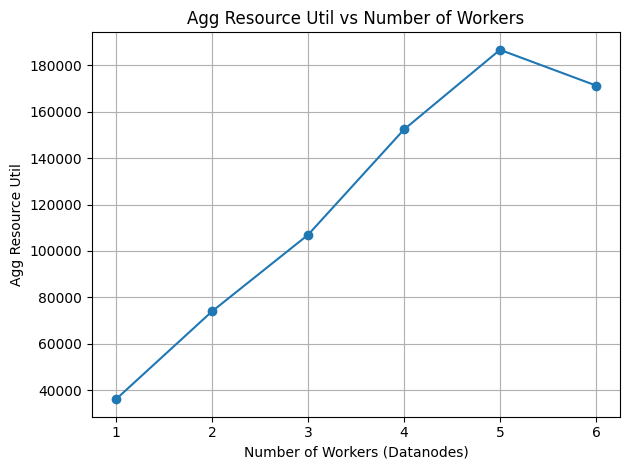

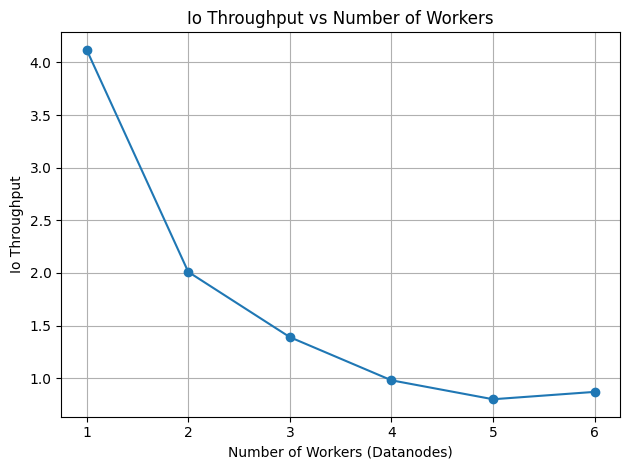

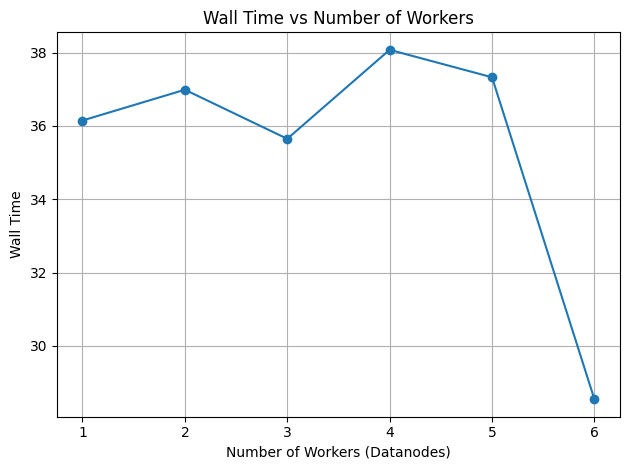

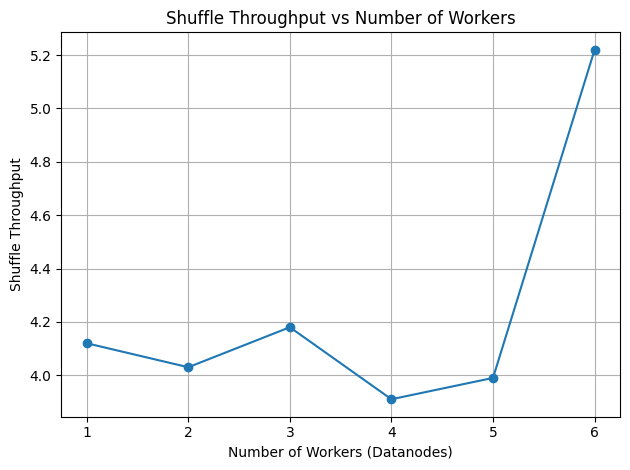

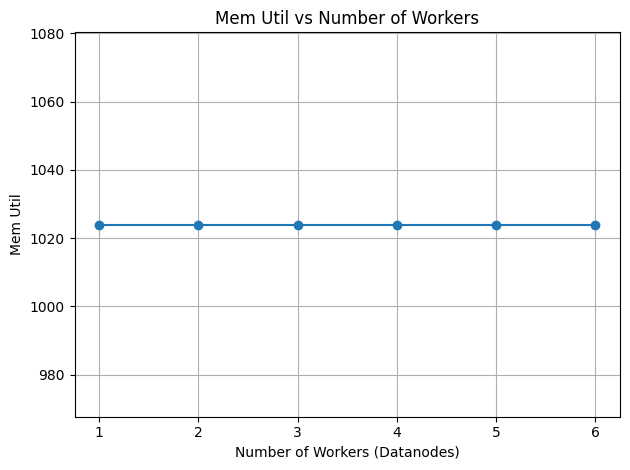

In [4]:
spark_results = get_spark_results(spark_log_files)
spark_df = pd.DataFrame(spark_results)


spark_metrics = spark_results[0].keys() - {'num_workers'}
spark_metrics = list(spark_metrics)

spark_df = spark_df.sort_values('num_workers')

for metric in spark_metrics:
    plt.figure()
    plt.plot(spark_df['num_workers'], spark_df[metric], marker='o')
    plt.xlabel('Number of Workers (Datanodes)')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'{metric.replace("_", " ").title()} vs Number of Workers')
    plt.grid(True)
    plt.tight_layout()


plt.show()


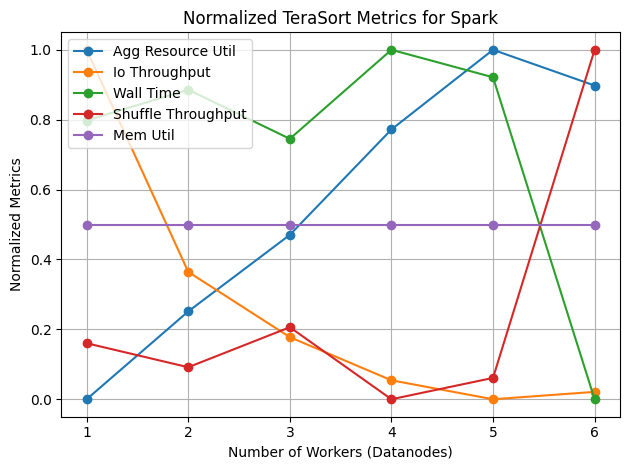

In [5]:
normalized_spark_df = spark_df.copy()

for metric in spark_metrics:
    col = normalized_spark_df[metric]
    col_min = col.min()
    col_max = col.max()
    if col_max != col_min:
        normalized_spark_df[metric] = (col - col.min()) / (col.max() - col.min())
    else:
        normalized_spark_df[metric] = 0.5

for metric in spark_metrics:
    plt.plot(normalized_spark_df['num_workers'], normalized_spark_df[metric], marker='o', label=metric.replace('_', ' ').title())
plt.xlabel('Number of Workers (Datanodes)')
plt.ylabel('Normalized Metrics')
plt.title('Normalized TeraSort Metrics for Spark')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

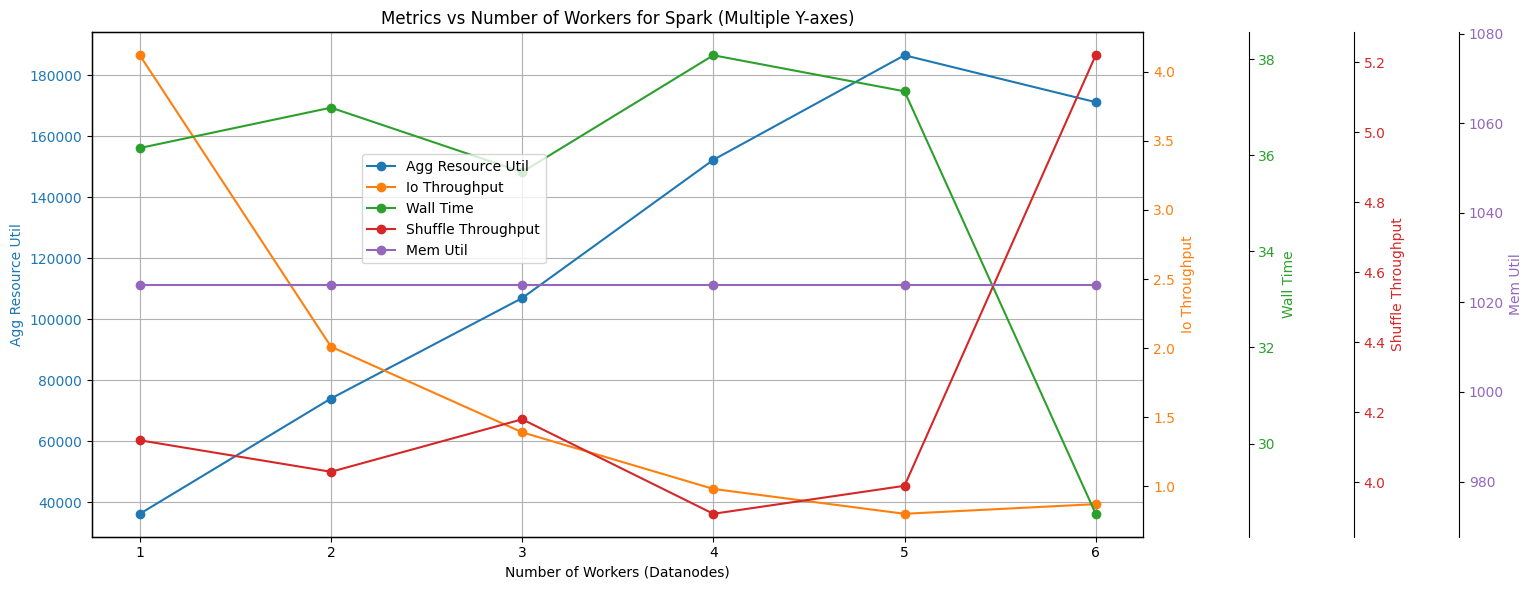

In [6]:
fig, ax1 = plt.subplots(figsize=(16, 6))

colors = plt.cm.tab10.colors  # 10 distinct colors
axes = [ax1]  # store all axes
lines = []

# Plot the first metric
metric = spark_metrics[0]
color = colors[0]
line, = ax1.plot(spark_df['num_workers'], spark_df[metric], marker='o', color=color, label=metric.replace('_', ' ').title())
ax1.set_ylabel(metric.replace('_', ' ').title(), color=color)
ax1.tick_params(axis='y', labelcolor=color)
lines.append(line)

# Plot remaining metrics
for i, metric in enumerate(spark_metrics[1:], start=1):
    ax = ax1.twinx()  
    axes.append(ax)
    
    ax.spines["right"].set_position(("axes", 1 + 0.1 * (i-1)))
    
    color = colors[i % len(colors)]
    line, = ax.plot(spark_df['num_workers'], spark_df[metric], marker='o', color=color, label=metric.replace('_', ' ').title())
    
    ax.set_ylabel(metric.replace('_', ' ').title(), color=color)
    ax.tick_params(axis='y', labelcolor=color)
    
    lines.append(line)

ax1.set_xlabel('Number of Workers (Datanodes)')
plt.title('Metrics vs Number of Workers for Spark (Multiple Y-axes)')
ax1.grid(True)

labels = [line.get_label() for line in lines]

plt.legend(lines, labels, loc='center left', bbox_to_anchor=(0.25, 0.65))

plt.tight_layout()
plt.show()

In [7]:
print(spark_df)

   num_workers  wall_time  shuffle_throughput  agg_resource_util  mem_util  \
4            1      36.15                4.12           36146.55    1024.0   
2            2      36.99                4.03           73980.10    1024.0   
1            3      35.65                4.18          106940.60    1024.0   
0            4      38.08                3.91          152314.37    1024.0   
3            5      37.33                3.99          186627.17    1024.0   
5            6      28.54                5.22          171243.98    1024.0   

   io_throughput  
4           4.12  
2           2.01  
1           1.39  
0           0.98  
3           0.80  
5           0.87  
